In [154]:
import polars as pl 
import polars.selectors as cs 
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from yahoo_fin.stock_info import get_data
import phoenix as px 
import umap
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.decomposition import KernelPCA
import utils
from dateutil.relativedelta import relativedelta 
import numpy as np
import seaborn.objects as so 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

ticker ="^990100-USD-STRD" #"^FTSE" #"^RUT" #"^GSPC" #"^VIX" #"^990100-USD-STRD"
n_components = 250

to test against MSCI: recuced with umap (2,3,?), and PCA

test against pct_change and raw data

## Getting data

In [144]:
sentences = pl.read_parquet(r"C:\Users\faune\Desktop\thesis\daily_headlines.parquet")
msci_world = get_data(ticker=ticker, start_date="2008-01-01", end_date="2016-01-01")
msci_close = pl.DataFrame(msci_world[['close']].dropna().pct_change().reset_index())
to_join = msci_close.drop_nulls().with_columns(pl.col('index').cast(pl.Date)).rename({'index': 'date'})
sentences = sentences.with_columns(pl.col('date').cast(pl.Date))
frame = sentences.join(to_join, on='date').with_columns(pl.col('date').dt.quarter().alias('quarter'), pl.col('date').dt.year().alias('year'))
reducer = umap.UMAP(n_components=n_components)
reduced = reducer.fit_transform(frame.select('embeddings').to_series().to_list())
decomposer = KernelPCA(n_components=3)
decomposed =decomposer.fit_transform(frame.select('embeddings').collect().to_series().to_list())


In [145]:
frame = frame.with_columns(pl.Series(name = 'reduced', values = reduced))
frame = frame.with_columns(pl.Series(name = 'decomposed', values = decomposed))

# sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'label').to_pandas(), x= 'x', y = 'y', hue='label', palette = sns.cubehelix_palette(n_colors=3))

In [146]:
frame = frame.sort('date').set_sorted('date').with_columns(pl.col('close').rolling_std(by='date', window_size = '1w').alias('std'))

In [147]:
frame = frame.drop_nulls()

In [148]:
frame = frame.with_columns(pl.col('close').rolling_mean(window_size = '1mo', by='date').alias('mean'))

## Getting lineplots

In [149]:
def get_linear_regression(x_col: str, y_col: str, df: pl.DataFrame, model_type: str, intercept: bool = True, start_year: int =2008):
    if model_type == 'ols':
        model = LinearRegression(fit_intercept=intercept)
    elif model_type == 'ridge':
        model = Ridge(fit_intercept=intercept)
    elif model_type == 'lasso':
        model = Lasso(fit_intercept=intercept)
    elif model_type == 'elastic net':
        model = ElasticNet(fit_intercept=intercept)

    df = df.filter(pl.col('date').dt.year().ge(start_year))

    X = df.select(pl.col(x_col)).to_series().to_list()
    y = df.select(pl.col(y_col)).to_series().to_list()
    
    ind = -int(len(X)/3)

    reg = model.fit(X[:ind], y[:ind])

    out_of_sample = np.dot(a=reg.coef_, b=np.transpose(X[ind:]))
    in_sample = reg.predict(X[:ind])
    predicted = np.append(in_sample, out_of_sample)

    with_predicted = df.with_columns(pl.Series(name = "predictions", values = predicted))
    with_predicted = with_predicted.select('date', y_col, 'predictions') 

    sns.set_theme(context='notebook', rc={'figure.figsize':(20,5)}, palette=sns.cubehelix_palette(2), style='white')
    sns.lineplot(data = with_predicted.to_pandas().set_index('date'))
    plt.axvline(with_predicted.select('date')[ind].to_series().to_list()[0], 0,1, color = 'blue')
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] + relativedelta(years=1), y = max(out_of_sample) + 0.05, s = "Out of Sample")

    # print("Coefficients: \n", reg.coef_)
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=0,s=f"Mean squared error (in sample): {mean_squared_error(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.01,s=f"Coefficient of determination (in sample): {r2_score(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.02,s=f"Mean squared error (out of sample): {mean_squared_error(y[ind:], out_of_sample):.2f}")
    plt.text(x=with_predicted.select('date')[0].to_series().to_list()[0] - relativedelta(years=3, month=10),y=-0.03,s= f"Coefficient of determination (out of sample): {r2_score(y[ind:], out_of_sample):.2f}")

    print(f"Mean squared error (in sample): {mean_squared_error(y[:ind], in_sample):.2f}")
    print(f"Coefficient of determination (in sample): {r2_score(y[:ind], in_sample):.2f}")
    print(f"Mean squared error (out of sample): {mean_squared_error(y[ind:], out_of_sample):.2f}")
    print(f"Coefficient of determination (out of sample): {r2_score(y[ind:], out_of_sample):.2f}")
    print(f"Average of the prediction : {np.mean(out_of_sample)}")
    print(f"Average of the true values : {np.mean(y[ind:])}")
    print(f"Std of the prediction : {np.std(out_of_sample)}")
    print(f"Std of the true values : {np.std(y[ind:])}")

    return

Mean squared error (in sample): 0.00
Coefficient of determination (in sample): 0.21
Mean squared error (out of sample): 0.00
Coefficient of determination (out of sample): -83.62
Average of the prediction : -0.007030504110640122
Average of the true values : -7.277308110384134e-05
Std of the prediction : 0.06214923940524443
Std of the true values : 0.006814888499697596


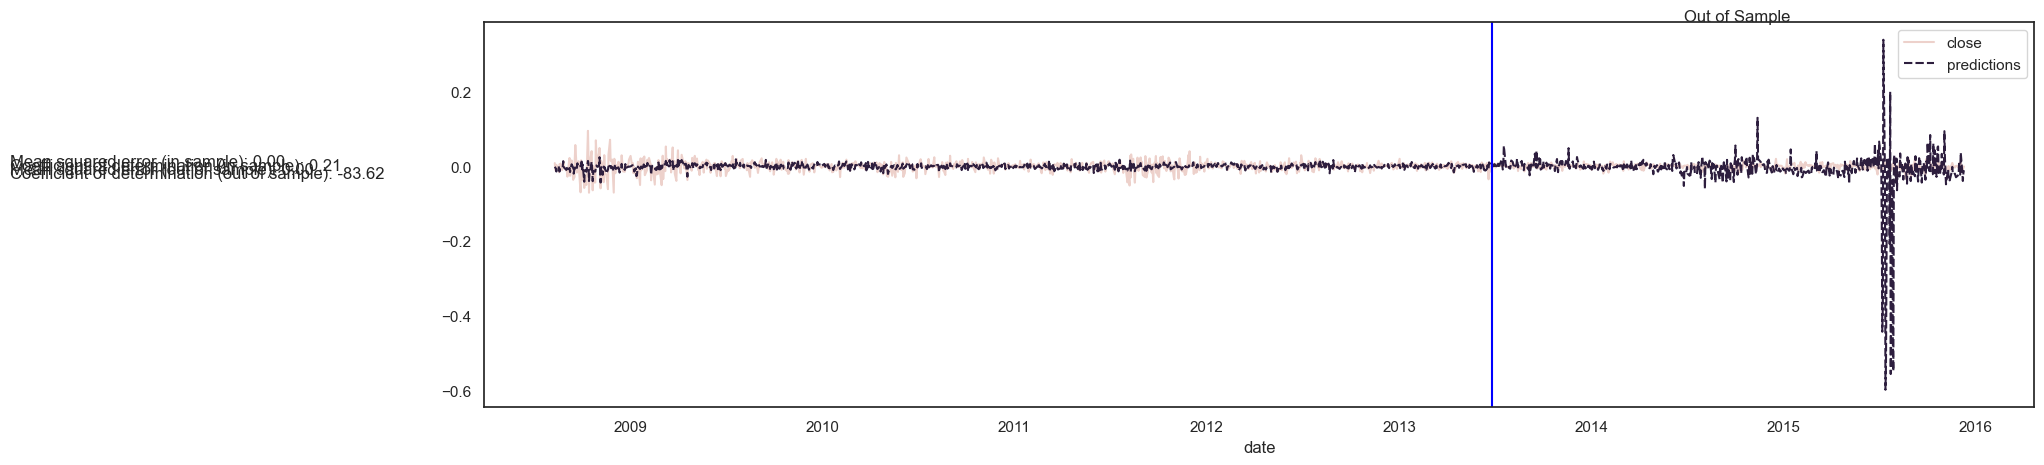

In [153]:
get_linear_regression(x_col='reduced', y_col='close', df=frame, model_type = 'ols', intercept = False, start_year = 2008)